[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/earthlab-education/ea-python-course-notebooks/blob/main/2022/blank-demos/04-uncertainty-lidar-raster-vector-blank.ipynb)

# LiDAR Uncertainty Demo

In [1]:
# Import libraries
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
#  This import helps you overlay raster and vector data nicely on a plot
from rasterio.plot import plotting_extent
import geopandas as gpd
# Zonal stats package for extracting values from a raster 
# There are several ways to do this
import rasterstats as rs
import earthpy as et
import earthpy.plot as ep

# Download data
et.data.get_data("spatial-vector-lidar")

# Navigate to data directory
os.chdir(os.path.join(et.io.HOME,
                      "earth-analytics",
                      "data"))

# What is a Canopy Height Model?

## Import Canopy Height Model
 

In [6]:
# Import CHM as xr
sjer_data_path = os.path.join("spatial-vector-lidar",
                              "california",
                              "neon-sjer-site")
sjer_chm_path = os.path.join(sjer_data_path,
                             "2013",
                             "lidar",
                             "SJER_lidarCHM.tif")
sjer_lidar_chm = rxr.open_rasterio(sjer_chm_path, masked=True).squeeze()

# Create a plotting extent if you wish to plot raster and vector data together
sjer_plot_extent = plotting_extent(sjer_lidar_chm.values,
                                   sjer_lidar_chm.rio.transform())

sjer_lidar_chm

(254571.0, 258867.0, 4107303.0, 4112362.0)

## Plot a histogram

Take note of the values in the  data. There are many 0's in the data

Question to ponder: What will a value of zero do to a calculation for max vs mean height?

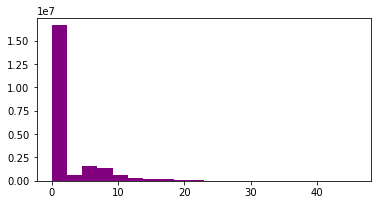

In [7]:
ep.hist(sjer_lidar_chm.values,
        figsize=(6, 3))
plt.show()

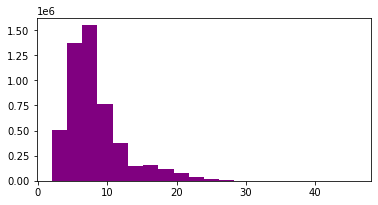

In [9]:
# Set all values that are 0 to nan (no data)
sjer_chm_data_no_zeros = sjer_lidar_chm.where(sjer_lidar_chm>0, np.nan)

ep.hist(sjer_chm_data_no_zeros.values,
        figsize=(6, 3))
plt.show()

## Import The Plot Location Data

In [11]:
# Open up your plot locations - shapefile
sjer_centroids_path = os.path.join(sjer_data_path,
                                   "vector_data",
                                   "SJER_plot_centroids.shp")

sjer_plot_points = gpd.read_file(sjer_centroids_path)

# Notice that the geometry is in POINT format now
sjer_plot_points.head(3)

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,POINT (255852.376 4111567.818)
1,SJER112,center,4111298.971,257406.967,trees,POINT (257406.967 4111298.971)
2,SJER116,center,4110819.876,256838.760,grass,POINT (256838.760 4110819.876)


## Remember that the plotting extent will help you overlay  your  data on a map

you won't need to create this plot for this assignment - this is just a refresher from last week.

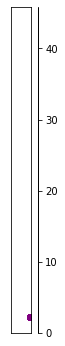

In [12]:
# The plot below looks funky -- look closely at the plot code
# Here, you can see that the extent is not provided for the raster data
fig, ax = plt.subplots(figsize=(6, 6))
ep.plot_bands(
    sjer_lidar_chm, 
    cmap="Greys",
    ax=ax, 
    scale=False)

# Overlay the geopandas VECTOR layer which contains data from your shapefile
sjer_plot_points.plot(ax=ax,
                      color="purple")
plt.show()

## Set  Your  Extent  and  The  Data  Overlay  Properly

See how the plot is now fixed and they overlay nicely.

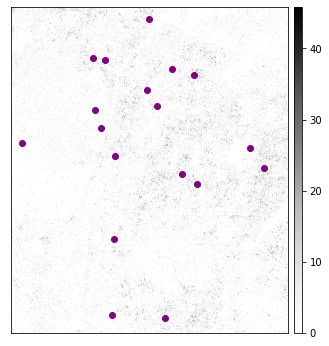

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
ep.plot_bands(
    sjer_lidar_chm, 
    cmap="Greys",
    extent=sjer_plot_extent,
    ax=ax,
    scale=False)

# Plot a geopandas VECTOR layer (shapefile in this case)
sjer_plot_points.plot(ax=ax,
                      color="purple")
plt.show()

# Buffer the points to make a polygon 

![Overlay Graphic](https://www.earthdatascience.org/images/earth-analytics/spatial-data/buffer-circular.png)

[This lesson](https://www.earthdatascience.org/courses/use-data-open-source-python/spatial-data-applications/lidar-remote-sensing-uncertainty/) will help you with the concept of an overlay.
Your plot data are points - individual x,y locations. But  each point represents an 
area (square in this case)  on th eground where tree heights were sampled by NEON field 
crews. You can  buffer each point to create a circle that represnets the  area on the ground
where trees were sampled. Then you can extract each pixel value that falls within the circle.

This approach is similar to the approach the field crews took when they went to the location 
and sampled all trees in that same area. 

QUESTION TO PONDER: consider how sampling on the ground may be 
different from what you can "see" on the ground using a lidar instrument.

In [15]:
# Buffer the points by 20 meter radius (NEON  Sites are 40m x 40m)
sjer_plots_poly = sjer_plot_points.copy()
sjer_plots_poly["geometry"] = sjer_plots_poly.geometry.buffer(20)

# View the top few lines
# Notice that the geometry is now in polygon rather than point format!
sjer_plots_poly.head()

,Plot_ID,Point,northing,easting,plot_type,geometry
0,SJER1068,center,4111567.818,255852.376,trees,"POLYGON ((255872.376 4111567.818, 255872.280 4..."
1,SJER112,center,4111298.971,257406.967,trees,"POLYGON ((257426.967 4111298.971, 257426.871 4..."
2,SJER116,center,4110819.876,256838.760,grass,"POLYGON ((256858.760 4110819.876, 256858.664 4..."
3,SJER117,center,4108752.026,256176.947,trees,"POLYGON ((256196.947 4108752.026, 256196.851 4..."
4,SJER120,center,4110476.079,255968.372,grass,"POLYGON ((255988.372 4110476.079, 255988.276 4..."


## Zonal Stats To Create Spatial Data 

In the example below, you run zonal stats. There are several parameters below that 
you don't need for your  homework.  I've marked them  as  optional with a comment below.

I have added additional steps below to show you how to run zonal stats and turn it into 
a spatial object that you can plot because often you do want to create a plot (and every year  
atleast one student asks me how to do it) :) 

run help(rs.zonal_stats) --to see what all of those parameters do below!

`help(rs.zonal_stats)` 

<- this is actually the function with the full docstring that you'll want to look at.

In [30]:
# Run zonal stats
sjer_lidar_tree_heights = rs.zonal_stats(
    sjer_plots_poly,
    sjer_lidar_chm.values,
    # This provides CRS information
    affine=sjer_lidar_chm.rio.transform(),
    # Optional if you want to plot
    geojson_out=True, 
    # Optional if you want to plot
    copy_properties=True, 
    # Ignore 0 - Thought Question: Why are we doing that?
    nodata=0, 
    stats=["mean", "max"]
)
sjer_lidar_tree_heights

[{'id': '0',
  'type': 'Feature',
  'properties': {'Plot_ID': 'SJER1068',
   'Point': 'center',
   'easting': 255852.376,
   'northing': 4111567.818,
   'plot_type': 'trees',
   'max': 19.049999237060547,
   'mean': 11.544347580915652},
  'geometry': {'type': 'Polygon',
   'coordinates': (((255872.376, 4111567.818),
     (255872.27969453344, 4111565.857657193),
     (255871.99170560806, 4111563.9161935598),
     (255871.51480671464, 4111562.012306455),
     (255870.85359065022, 4111560.164331353),
     (255870.01442528696, 4111558.3900652635),
     (255869.00539224604, 4111556.7065953393),
     (255867.83620906723, 4111555.1301343166),
     (255866.51813562372, 4111553.675864376),
     (255865.06386568327, 4111552.3577909325),
     (255863.48740466038, 4111551.1886077537),
     (255861.8039347365, 4111550.179574713),
     (255860.0296686473, 4111549.3404093497),
     (255858.18169354508, 4111548.6791932853),
     (255856.2778064403, 4111548.202294392),
     (255854.33634280658, 4111547

In [32]:
# While you don't need a GDF to do this analysis 
# This will allow you to plot the data later by tree height!!
sjer_lidar_height_df = gpd.GeoDataFrame.from_features(sjer_lidar_tree_heights)
sjer_lidar_height_df.head()

,geometry,Plot_ID,Point,easting,northing,plot_type,max,mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,255852.376,4111567.818,trees,19.049999,11.544348
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,257406.967,4111298.971,trees,24.019999,10.369277
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,256838.760,4110819.876,grass,16.070000,7.518398
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,256176.947,4108752.026,trees,11.059999,7.675347
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,255968.372,4110476.079,grass,5.740000,4.591176


Important: When you rename columns in Pandas - you want to add the columns = 
parameter to the function. Why? Run  help on `.rename` and look at the order of 
parameter values. `columns` doesn't come first! This means that pandas doesn't know
what to do with a dictionary unless you use the columns parameter name explicetly.

In [43]:
# Optional but recommended
# Rename columns to be clear about what metrics they contain
sjer_lidar_height_df.rename(
    columns={'max': 'chm_max', 'mean': 'chm_mean'},
    inplace=True)

# Look at the new column names. they are more expressive than they were before.
# This will become important as you merge the insitu data with this data below!
sjer_lidar_height_df.head()

,geometry,Plot_ID,Point,easting,northing,plot_type,chm_max,chm_mean
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,255852.376,4111567.818,trees,19.049999,11.544348
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,257406.967,4111298.971,trees,24.019999,10.369277
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,256838.760,4110819.876,grass,16.070000,7.518398
3,"POLYGON ((256196.947 4108752.026, 256196.851 4...",SJER117,center,256176.947,4108752.026,trees,11.059999,7.675347
4,"POLYGON ((255988.372 4110476.079, 255988.276 4...",SJER120,center,255968.372,4110476.079,grass,5.740000,4.591176


## Compare Human Measured Tree Heights
Next you will import the data that has human measured tree heights. 
You will compare this data to the lidar data values that you calculated above!

You are using `Pandas` here to summarize a dataframe just like you did in the fall Bootcamp.

In [44]:
# Import the csv of human measured (insitu) tree height data
path_insitu = os.path.join(sjer_data_path,
                           "2013",
                           "insitu",
                           "veg_structure",
                           "D17_2013_SJER_vegStr.csv")
sjer_insitu_all = pd.read_csv(path_insitu)

sjer_insitu_all.head(3)

,siteid,sitename,plotid,easting,northing,taxonid,scientificname,indvidual_id,pointid,individualdistance,...,canopyform,livingcanopy,inplotcanopy,materialsampleid,dbhqf,stemmapqf,plant_group,common_name,aop_plot,unique_id
0,SJER,San Joaquin,SJER128,257085.7,4111381.5,PISA2,Pinus sabiniana,1485,center,9.7,...,NaN,100,100,NaN,0,0,NaN,NaN,NaN,NaN
1,SJER,San Joaquin,SJER2796,256047.7,4111548.5,ARVI4,Arctostaphylos viscida,1622,NE,5.8,...,Hemisphere,70,100,f095,0,0,NaN,NaN,NaN,NaN
2,SJER,San Joaquin,SJER272,256722.9,4112170.2,ARVI4,Arctostaphylos viscida,1427,center,6.0,...,Hemisphere,35,100,NaN,0,0,NaN,NaN,NaN,NaN


I often like to clean up my data as I go. if there a re many additional 
columns, then I drop the ones that I don't need or select the ones that I do need.

In [46]:
# Keep only the needed columns
# This is one way to subset a pandas dataframe by column name
sjer_insitu = sjer_insitu_all[["siteid", "sitename", "plotid", "stemheight"]]

# See how much cleaner that is?
sjer_insitu

,siteid,sitename,plotid,stemheight
0,SJER,San Joaquin,SJER128,18.2
1,SJER,San Joaquin,SJER2796,3.3
2,SJER,San Joaquin,SJER272,1.7
3,SJER,San Joaquin,SJER112,2.1
4,SJER,San Joaquin,SJER272,3.0
...,...,...,...,...
357,SJER,San Joaquin,SJER8,0.8
358,SJER,San Joaquin,SJER8,0.7
359,SJER,San Joaquin,SJER8,0.8
360,SJER,San Joaquin,SJER8,0.0


Below you are calculating the mean and max height value for each plot. you are using the `stemheight` column to calculate these values. This is similar to what you did in the Bootcamp in the fall with Pandas!

In [58]:
# Get mean and max tree height for each plot
insitu_stem_ht = (
    sjer_insitu
    .groupby('plotid')
    .agg(['mean', 'max'])
    ['stemheight'].reset_index()
)

# Optional  - remove the index and turn it into a regular column
insitu_stem_ht = insitu_stem_ht.reset_index()
insitu_stem_ht.head()

,index,plotid,mean,max
0,0,SJER1068,3.866667,19.3
1,1,SJER112,8.221429,23.9
2,2,SJER116,8.218750,16.0
3,3,SJER117,6.512500,11.0
4,4,SJER120,7.600000,8.8


## Rename Columns
Renaming columns can be useful to keep your data tidy and to keep track of what columns contains what metrics.

If you end up with two columns called **max**, how will you know which is lidar derived and which 
is *in situ* derived?

In [59]:
# It could be a good idea to rename columns so the data are clear
insitu_stem_ht.rename(columns={"mean": "insitu_mean",
                               "max": "insitu_max"},
                      inplace=True)
insitu_stem_ht.head()

,index,plotid,insitu_mean,insitu_max
0,0,SJER1068,3.866667,19.3
1,1,SJER112,8.221429,23.9
2,2,SJER116,8.218750,16.0
3,3,SJER117,6.512500,11.0
4,4,SJER120,7.600000,8.8


Once you are done, you can then MERGE the human measured tree height 
data sumnmarized above with the lidar summaries that you created. 
This creates ONE dataframe with all of the data you need to run your 
comparisons. 

In [61]:
# Merge the lidar df with the insitu by the plot id
sjer_final_height = (
    sjer_lidar_height_df
    .merge(
        insitu_stem_ht,
        left_on='Plot_ID', 
        right_on='plotid'))

In [62]:
# Notice how the expressive column names help make this table easier  to 
# understand
sjer_final_height.head(3)

,geometry,Plot_ID,Point,easting,northing,plot_type,chm_max,chm_mean,index,plotid,insitu_mean,insitu_max
0,"POLYGON ((255872.376 4111567.818, 255872.280 4...",SJER1068,center,255852.376,4111567.818,trees,19.049999,11.544348,0,SJER1068,3.866667,19.3
1,"POLYGON ((257426.967 4111298.971, 257426.871 4...",SJER112,center,257406.967,4111298.971,trees,24.019999,10.369277,1,SJER112,8.221429,23.9
2,"POLYGON ((256858.760 4110819.876, 256858.664 4...",SJER116,center,256838.760,4110819.876,grass,16.070000,7.518398,2,SJER116,8.218750,16.0


## Bonus! A Spatial Plot

Below you can just see how you created a new dataset that can also be plotted spatially which is pretty cool!!
This  is just a demo - you  don't need to do this for your homework assignment! 

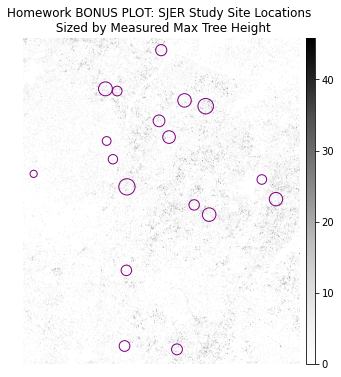

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
ep.plot_bands(sjer_lidar_chm, cmap="Greys",
              extent=sjer_plot_extent,
              ax=ax,
              scale=False)

# Overlay field site locations
sjer_final_height.centroid.plot(
    ax=ax,
    marker='o',
    markersize=sjer_final_height['insitu_max']*10,
    edgecolor='purple',
    color='none')

# Add title
ax.set_title((
    "Homework BONUS PLOT: "
    "SJER Study Site Locations \n Sized by Measured Max Tree Height"))
ax.set_axis_off()